In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import pickle
import logging
#logging.basicConfig(level=logging.DEBUG)

# Integration

In [2]:
a = np.arange(0,3)
b = [3,2,1]
#b = np.arange(3,0,-1)
print(a)
print(b)
a*b

[0 1 2]
[3, 2, 1]


array([0, 2, 2])

In [3]:
def save_obj(obj, name):
    with open('obj/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
    
def quad_Gauss(f, a, b, N):
    """
    Approximate the integral of any (callable) function f
    on the interval a,b
    using Gauss Quadrature with N support points.
    Weights/support points are loaded for the reference interval [0,1]
    and must be transformed to the integration interval.
    """
    try:
        weights = load_obj("testat2_lambda")[N]
    except KeyError as e:
        print("Weights for N={} not available".format(N))
        return
    
    try:
        support_points = load_obj("testat2_tau")[N]
    except KeyError as e:
        print("Gausspts for N={} not available".format(N))
        return
    
    logging.debug("quad: Gauss pts: {}".format(support_points))
    support_points = [a + (b-a)*t for t in support_points]  # transformation to a-b
    function_values = [f(t) for t in support_points]
    logging.debug("quad: Gauss pts transformed: {}".format(support_points))
    logging.debug("quad: f @ Gauss pts: {}".format(function_values))
    logging.debug("quad: weights: {}".format(weights))
    
    return float((b-a) * np.sum(np.multiply(weights,function_values)))


# Ansatzfunctions

In [4]:
def phi(x, i, vx):
    """
    Piecewise linear ansatzfunction
    Returns np.ndarray of values phi_i(x)
    
    x:
    i:  index of ansatzfunktion
    vx: node vector (discretization)
    """
    
    if not type(x) == np.ndarray:
        x = np.array([x])
        
    phi = np.zeros(len(x))
    for n,x_ in enumerate(x):
        if i == 0 and x_ == vx[0]:
            phi[n] = 1.0
        elif i == len(vx)-1 and x_ == vx[-1]:
            phi[n] = 1.0
        elif vx[i-1] <= x_ < vx[i]:
            assert i != 0
            phi[n] = (x_ - vx[i-1])/(vx[i] - vx[i-1])
        elif vx[i] <= x_ < vx[i+1]:
            phi[n] = (x_ - vx[i+1])/(vx[i] - vx[i+1])
        else: 
            phi[n] = 0        
    return phi

def dphi(x, i, vx):
    """
    Derivative of piecewise linear ansatzfunction by x
    Returns np.ndarray of values dphi_i(x)
    
    x:
    i:  index of ansatzfunktion
    vx: node vector (discretization)
    """
    
    numpyarray = True
    if not type(x) == np.ndarray:
        x = np.array([x])
        numpyarray = False
        
    dphi = np.zeros(len(x))
    for n,x_ in enumerate(x):
        if i == 0 and x_ == vx[0]:
            dphi[n] = -1.0
        elif i == len(vx)-1 and x_ == vx[-1]:
            dphi[n] = 1.0
        elif vx[i-1] < x_ <= vx[i]:
            assert i != 0
            dphi[n] = 1/(vx[i] - vx[i-1])
        elif vx[i] < x_ < vx[i+1]:
            dphi[n] = 1/(vx[i] - vx[i+1])
        else: 
            dphi[n] = 0
            
    if not numpyarray:
        return float(dphi)
    else:
        return dphi

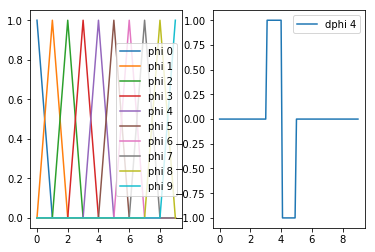

In [5]:
fig, (ax1,ax2) = plt.subplots(1,2)

vx = np.array([0,1,2,3,4,5,6,7,8,9])

x = np.linspace(0,max(vx),100)
#print(x)
    
for i in range(len(vx)):
#    print(phi(x, i, vx))
    ax1.plot(x,  phi(x, i, vx), label="phi {}".format(i))
    if i in [4]:
        ax2.plot(x, dphi(x, i, vx), label="dphi {}".format(i))

ax1.legend()
ax2.legend()
plt.show()

# Assembly

In [6]:
def IntegrateFunction(aa, bb, func, order, i, k, vx):
    """
    Integrates func(x) ∂φi(x) ∂φk(x) dx on [aa,bb]
    using Gauss Quadrature
    
    order: specifies number of integration points
    
    """
    
    f = lambda x: func(x) * dphi(x, i, vx) * dphi(x, k, vx)
    return quad_Gauss(f, aa, bb, N = order)
    


def NodeStiffness(i, vx, f, order):
    """
    Get contributions to stiffness matrix from node i
    
    Parameters:
        i: node id
        vx: node vector
        f: function ?
        order: number of integration points to use
    Returns (ii,jj,vv):
            ii: row indices
            jj: column indices
            vv: values
    """
    nvx = len(vx)
    
    iijjvv = []

    if i == 0:
        a = vx[0]
        b = vx[1]
        v = IntegrateFunction(a, b, f, order, i, 0, vx)
        iijjvv.append((i,0,v))
        v = IntegrateFunction(a, b, f, order, i, 1, vx)
        iijjvv.append((i,1,v))
    elif i == nvx-1:
        a = vx[-2]
        b = vx[-1]
        v = IntegrateFunction(a, b, f, order, i, i-1, vx)
        iijjvv.append((i,i-1,v))
        v = IntegrateFunction(a, b, f, order, i, i, vx)
        iijjvv.append((i,i  ,v))
    else:
        a = vx[i-1]
        b = vx[i]
        v = IntegrateFunction(a, b, f, order, i, i-1, vx) 
        iijjvv.append((i,i-1,v))
        v = IntegrateFunction(a, b, f, order, i, i, vx)
        iijjvv.append((i,i,v))
        
        a = vx[i]
        b = vx[i+1]
        v = IntegrateFunction(a, b, f, order, i, i, vx)
        iijjvv.append((i,i,v))
        v = IntegrateFunction(a, b, f, order, i, i+1, vx)
        iijjvv.append((i,i+1,v))
        
    ii,jj, vv = zip(*iijjvv)
    
    return ii, jj, vv

In [14]:
# doctest this!


EA = lambda x: 1
vx = np.array([0,1,2])

for e in range(len(vx)):
    print()
    print("Knoten {}:".format(e))
    ii,jj,vv = NodeStiffness(e, vx, EA, order = 1)
    Ke = scipy.sparse.csr_matrix((vv, (ii, jj)), shape=[len(vx),len(vx)])
    print(Ke.toarray())


Knoten 0:
[[ 1. -1.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]

Knoten 1:
[[ 0.  0.  0.]
 [-1.  2. -1.]
 [ 0.  0.  0.]]

Knoten 2:
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0. -1.  1.]]
